In [165]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

# Initialising unknown function and data

In [166]:
f = lambda x: np.multiply(np.sin(3*x), np.exp(-np.power(x,2)))

In [167]:
n_train = 8
n_test = 200
s = 0.001

In [168]:
X_train = np.random.uniform(-4,4,size=(n_train,1))
y_train = f(X_train) + s*np.random.randn(n_train,1)
y_train = y_train.reshape(-1,1)

In [169]:
print(X_train.shape)
print(y_train.shape)

(8, 1)
(8, 1)


In [170]:
X_test = np.linspace(-5,5,n_test)
y_test = f(X_test) + s*np.random.randn(n_test)
X_test = X_test.reshape(-1,1)
y_test = y_test.reshape(-1,1)

In [171]:
print(X_test.shape)
print(y_test.shape)

(200, 1)
(200, 1)


<IPython.core.display.Javascript object>


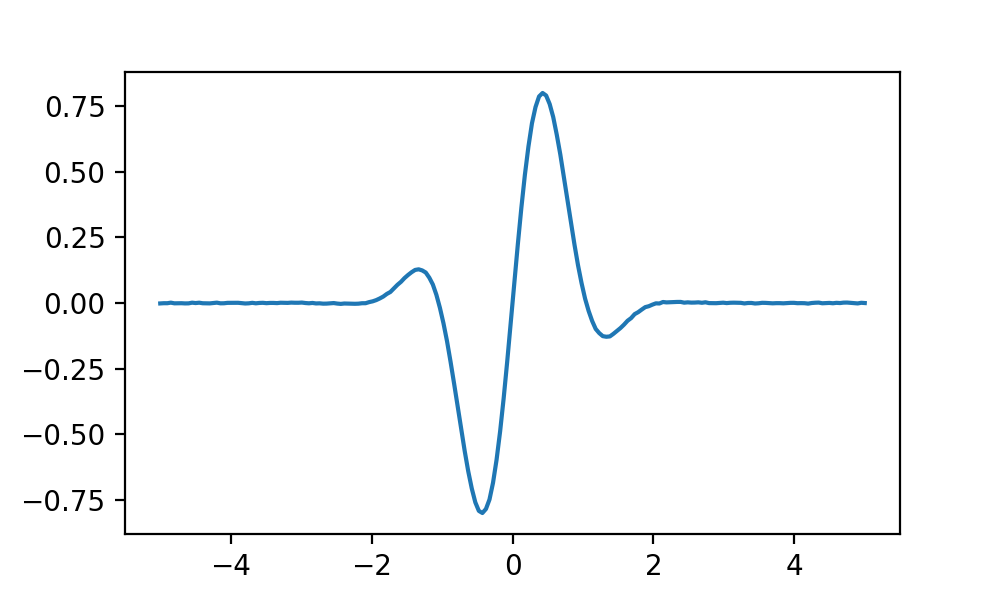

In [172]:
plt.figure()
plt.plot(X_test,y_test)

# GP regression: Training kernel hyperparameters

In [173]:
from IPython.display import display
import GPy

In [174]:
def initialiseGP(X_train,y_train):
    # Choose a kernel, here we use a squared exponential kernel
    k = GPy.kern.RBF(1, variance=np.exp(-1), lengthscale=1.)
    m = GPy.models.GPRegression(X_train,y_train,k)
    return m

In [175]:
m = initialiseGP(X_train,y_train)

In [176]:
# Train kernel hyperparameters, by optimising the marginal likelihood
m.optimize_restarts(num_restarts = 5)

Optimization restart 1/5, f = -14.013574081711768
Optimization restart 2/5, f = -14.013573611449957
Optimization restart 3/5, f = -12.160152846988458
Optimization restart 4/5, f = -14.013574085982274
Optimization restart 5/5, f = -14.013572335862799


In [177]:
display(m)

# GP regression: Bayesian inference 

In [178]:
# The outputs of GP inference are the predicted mean and variance
y_mu, y_s2 = m.predict(X_test)

In [179]:
y_s = np.sqrt(y_s2)

<IPython.core.display.Javascript object>


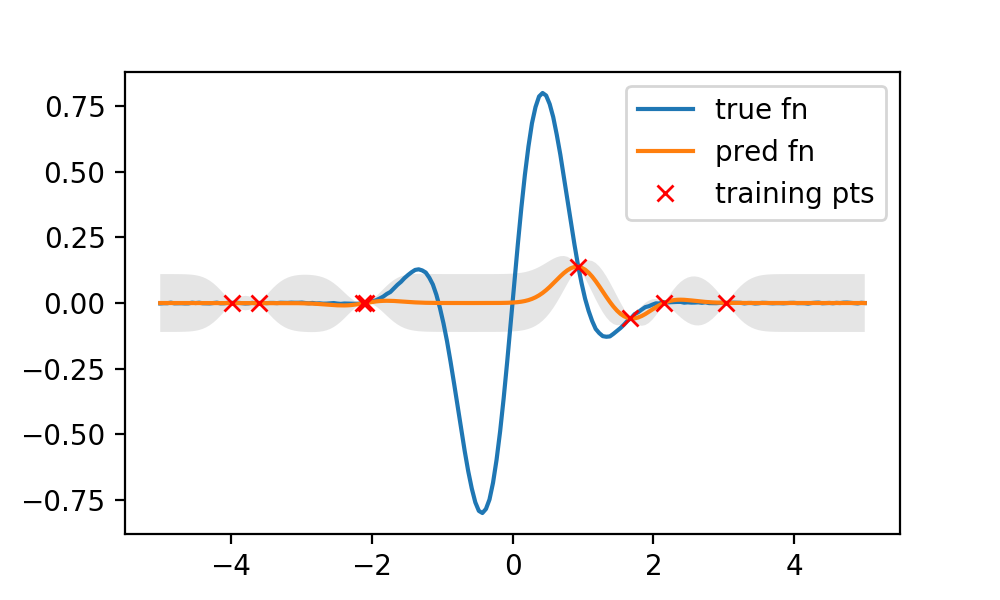

In [180]:
plt.figure()
plt.plot(X_test,y_test, label="true fn")
plt.plot(X_test,y_mu, label="pred fn")
plt.fill_between(np.squeeze(X_test), np.squeeze(y_mu-2*y_s), np.squeeze(y_mu+2*y_s), facecolor='grey', alpha=0.2)
plt.plot(X_train,y_train,'rx', label="training pts")
plt.legend()

# Interactive portion

In [181]:
def addTrainingPoint(X_train,y_train,x_new,y_new):    
    X_train = np.append(X_train,x_new)
    y_train = np.append(y_train,y_new)
    return X_train.reshape(-1,1), y_train.reshape(-1,1)

<IPython.core.display.Javascript object>


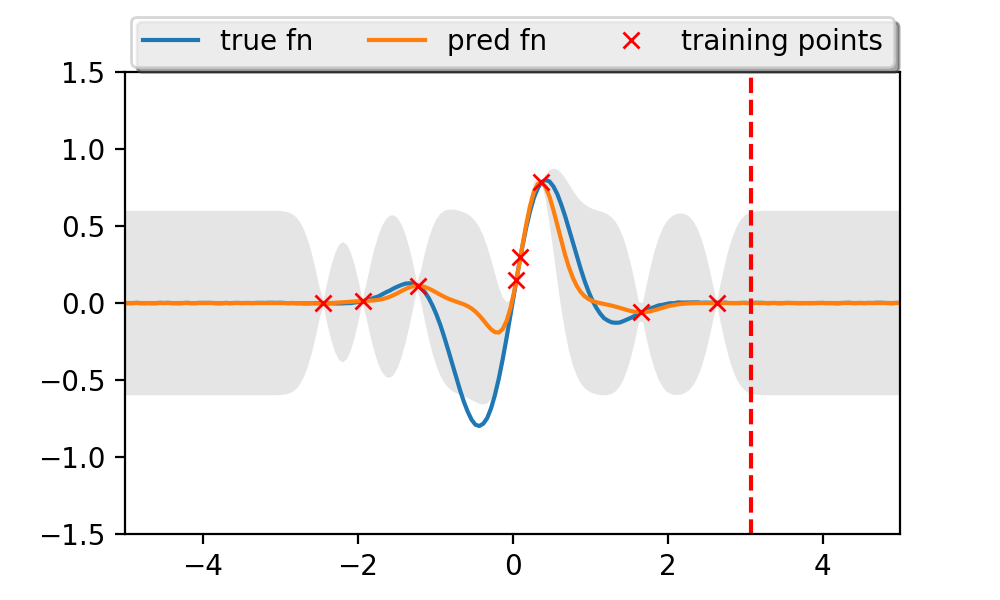

A Jupyter Widget

A Jupyter Widget

In [188]:
import ipywidgets
from IPython.core.pylabtools import figsize

# Reset training data
X_train = np.random.uniform(-4,4,size=(n_train,1))
y_train = f(X_train) + s*np.random.randn(n_train,1)
y_train = y_train.reshape(-1,1)

# Reset GP
m = initialiseGP(X_train,y_train)
m.optimize(max_iters=100)

# Sample once
x_new = np.random.uniform(low=-4, high=4, size=1)

# Initialise plot
fig,ax = plt.subplots(1,1)
ax.set_xlim(-5,5)
ax.set_ylim(-1.5,1.5)

line_true, = ax.plot(X_test,y_test, label="true fn")
line_pred, = ax.plot(X_test,y_mu, label="pred fn")
line_next = ax.axvline(x_new,-1.5,1.5,color='r', linestyle="dashed")
pts_train, = ax.plot(X_train,y_train,'rx', label="training points")
plt.fill_between(np.squeeze(X_test), np.squeeze(y_mu-2*y_s), np.squeeze(y_mu+2*y_s), facecolor='grey', alpha=0.2)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),
          ncol=3, fancybox=True, shadow=True)

add_button = ipywidgets.Button(description="Add training point")
reset_button = ipywidgets.Button(description="Reset")
figsize(5, 3)

def addAndRetrain(b):
    global X_train,y_train,x_new,m
    # Add new training point based on x_new
    y_new = f(x_new) + s*np.random.randn(1,1)
    X_train,y_train = addTrainingPoint(X_train,y_train,x_new,y_new)    
    retrain()
    replot()

def reset(b):
    global X_train,y_train,x_new,m
    X_train = np.random.uniform(-4,4,size=(n_train,1))
    y_train = f(X_train) + s*np.random.randn(n_train,1)
    y_train = y_train.reshape(-1,1)
    retrain()
    replot()

def retrain():
    global X_train,y_train,x_new,y_mu,y_s,m
    # Sample next training point
    x_new = np.random.uniform(low=-4, high=4, size=1) 
    
    # Retrain GP
    m.set_XY(X_train,y_train)
    m.optimize(max_iters=100)
    
    # Generate predictions
    y_mu, y_s2 = m.predict(X_test)
    y_s = np.sqrt(y_s2)

def replot():
    # Update plot
    for coll in (ax.collections): ax.collections.remove(coll)
    line_pred.set_data(X_test,y_mu)
    pts_train.set_data(X_train,y_train)
    line_next.set_xdata(x_new)
    plt.fill_between(np.squeeze(X_test), np.squeeze(y_mu-2*y_s), np.squeeze(y_mu+2*y_s), facecolor='grey', alpha=0.2)
    fig.canvas.draw()
    
add_button.on_click(addAndRetrain)
reset_button.on_click(reset)
display(add_button)
display(reset_button)